<a href="https://colab.research.google.com/github/KyleEtera/MAT422/blob/main/3_5_K_means_and_3_6_Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install kneed

In [57]:
import matplotlib.pyplot as plt, numpy as np, cvxopt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist

**3.5 K-means** - K-Means is an unsupervised learning algorithm that is used to cluster data by taking guesses on where a set number of centroids would be until convergence. Once it's found the centers of the clusters, it assigns each value in your dataset to one of those clusters based on how close it is to the centroid.

In [52]:
features, labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2,
    random_state=21
    )
features[:5]

array([[ -8.76835415, -10.77322415],
       [ -4.78269982,  -8.94303558],
       [-11.42776077,  -2.30418094],
       [  2.10959955,  -8.19184958],
       [ -6.88905608,  -6.60689354]])

In [15]:
labels[:5]

array([2, 2, 0, 1, 0])

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[-0.84396161, -0.98362911],
       [-0.20562671, -0.42516278],
       [-1.26988718,  1.60062674],
       [ 0.89823101, -0.19594482],
       [-0.54297676,  0.28769092]])

In [31]:
km = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=21
    )
km.fit(scaled_features)
km.inertia_

89.40899730718884

In [32]:
km.cluster_centers_

array([[-0.89711413,  1.12757824],
       [-0.40107585, -0.48207769],
       [ 1.29960733, -0.67672045]])

In [33]:
km.n_iter_

13

In [34]:
km.labels_[:5]

array([1, 1, 0, 2, 1], dtype=int32)

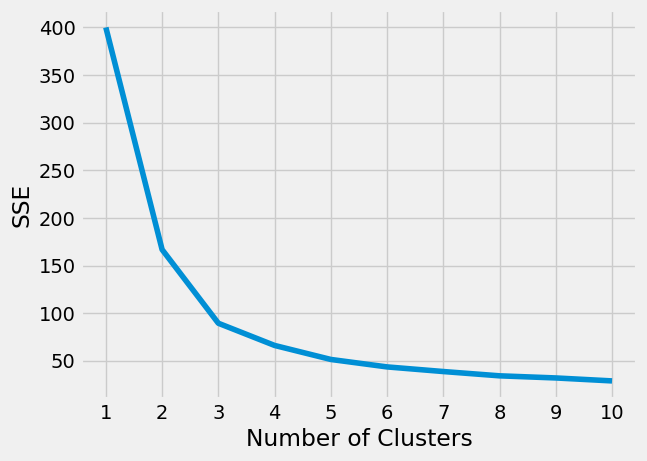

In [35]:
kmeans_kwargs = {
     "init": "random",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 42,
       }

sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

  plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

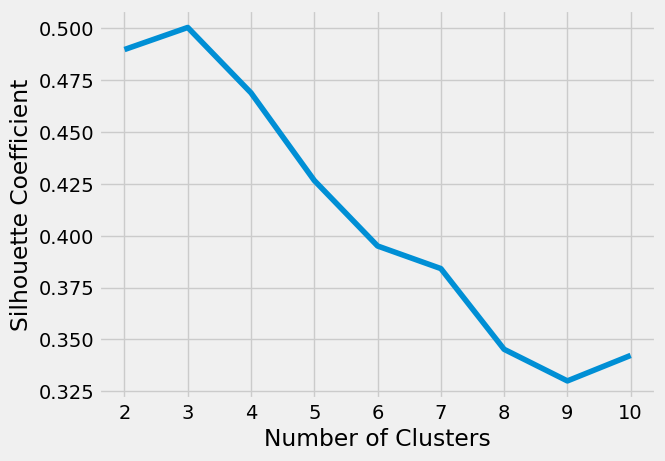

In [40]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )

silhouette_coefficients = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  score = silhouette_score(scaled_features, kmeans.labels_)
  silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

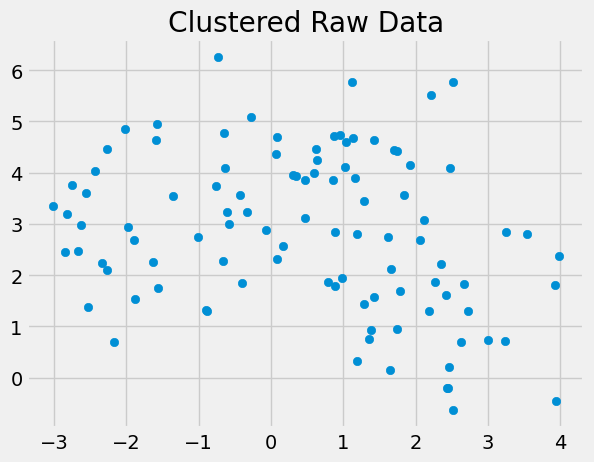

In [46]:
def k_means(X, k, n_iter):
    n_samples, n_features = X.shape

    # Initialize centroids
    centroids = np.random.rand(k, n_features)

    # Initialize clusters
    clusters = np.zeros(n_samples)

    for _ in range(n_iter):
        # Use WCSS to assign each sample to the closest centroid
        clusters = np.argmin(cdist(X, centroids), axis=1)

        # Update centroids
        for i in range(k):
            centroids[i] = np.mean(X[clusters == i], axis=0)

    return clusters, centroids

X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=0)
""" Data Format
X = [
    [x1, y1],
    [x2, y2],
    ...
    [xn, yn]
]

y = [(0|1|2),...]
"""

plt.scatter(X[:, 0], X[:, 1])
plt.title("Clustered Raw Data")
plt.show()

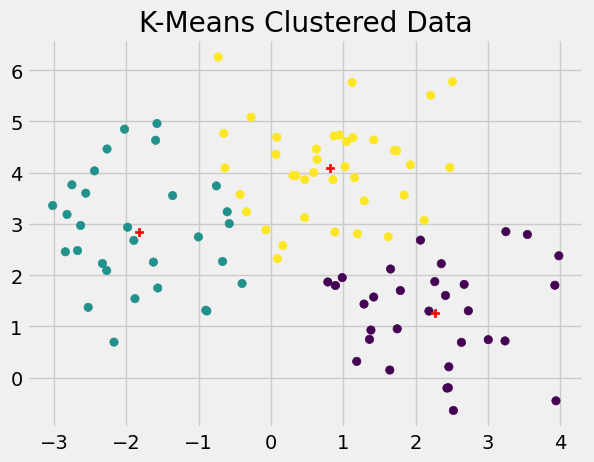

In [61]:
clusters, centroids = k_means(X, 3, 10)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='P', c='r')
plt.title("K-Means Clustered Data")
plt.show()

**3.6 Support Vector Machines** - Unlike K-Means, SVM is a supervised learning model used for classification problems and regression analysis. The support vectors are the data points closest to the line we use to seperate the data into classses, the hyperplane, using the margin which is the distance between the hyperplane and those closest data points.

We can then determine the performance of the model using a loss function.

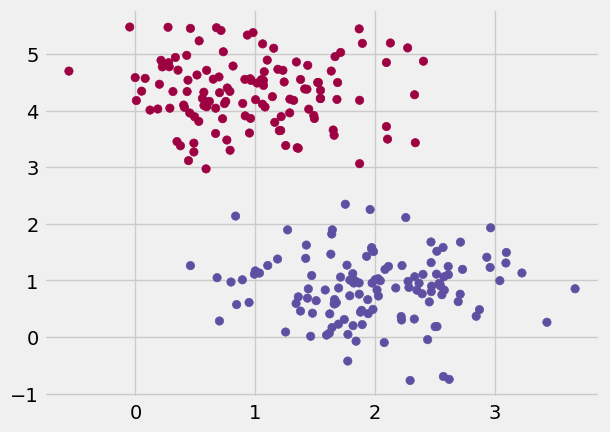

In [66]:
class SVM:
  def fit(self, X, y):
        n_samples, n_features = X.shape
# P = X^T X
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
# q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
# A = y^T
        A = cvxopt.matrix(y, (1, n_samples))
# b = 0
        b = cvxopt.matrix(0.0)
# -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
# 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
# Lagrange multipliers
        a = np.ravel(solution['x'])
# Lagrange have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
# Intercept
        self.b = 0
        for n in range(len(self.a)):
          self.b += self.sv_y[n]
          self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
          self.b /= len(self.a)
# Weights
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
          self.w += self.a[n] * self.sv_y[n] * self.sv[n]

  def project(self, X):
      return np.dot(X, self.w) + self.b


  def predict(self, X):
      return np.sign(self.project(X))

X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svm = SVM()
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.8226e+01 -3.4458e+01  6e+02  2e+01  2e+00
 1: -2.5252e+01 -1.8773e+01  2e+02  9e+00  7e-01
 2: -5.3459e+01 -3.2711e+01  2e+02  7e+00  6e-01
 3: -7.8360e+01 -2.6482e+01  1e+02  4e+00  3e-01
 4: -5.6818e+00 -5.1750e+00  1e+01  2e-01  1e-02
 5: -3.6906e+00 -4.1082e+00  4e-01  4e-16  1e-14
 6: -4.0061e+00 -4.0104e+00  4e-03  9e-16  5e-15
 7: -4.0094e+00 -4.0094e+00  4e-05  6e-16  6e-15
 8: -4.0094e+00 -4.0094e+00  4e-07  2e-15  5e-15
Optimal solution found.


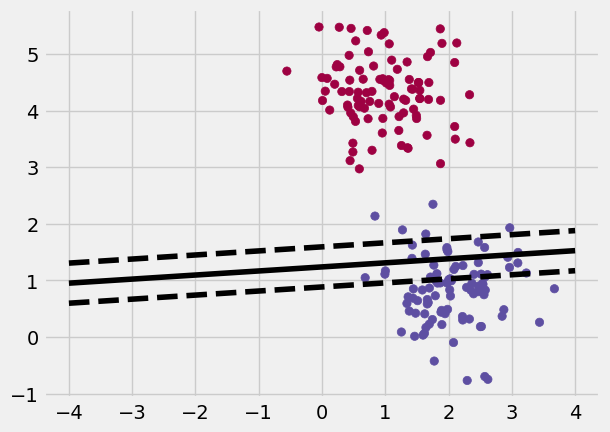

In [69]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='Spectral')
# w.x + b = 0
a0 = -4; a1 = f(a0, svm.w, svm.b)
b0 = 4; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')
# w.x + b = 1
a0 = -4; a1 = f(a0, svm.w, svm.b, 1)
b0 = 4; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')
# w.x + b = -1
a0 = -4; a1 = f(a0, svm.w, svm.b, -1)
b0 = 4; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

In [70]:
y_pred = svm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 7, 27]])

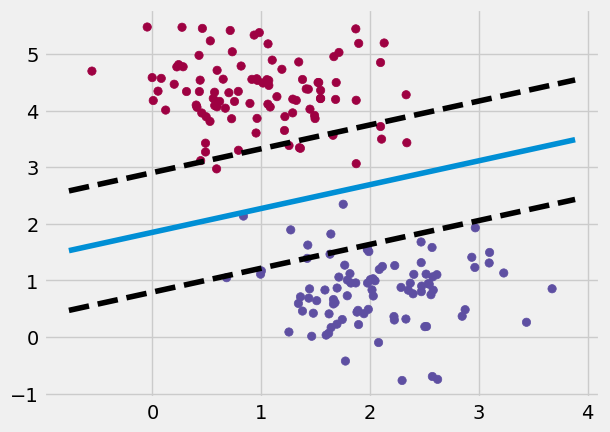

In [72]:
svc = LinearSVC()
svc.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='Spectral');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

In [73]:
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]])

Sources: [madonnajorin](https://github.com/madonnaojorin/MAT494/blob/main/3.5_K_means_3.6_Support_Vector_Machine.ipynb) and [punitarani](https://github.com/punitarani/MAT-494/blob/master/3.5-6%20K-Means%20and%20SVM.ipynb)